In [59]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random
import collections
import seaborn as sns
from math import *
from sklearn import cluster, datasets, mixture
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import knn as knn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
N_A = 10
N_B = 100
N_test = 200
N=1500
d=2
x_min, x_max = -2, 3
y_min, y_max = -1.5, 2
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
X_all=np.c_[xx.ravel(), yy.ravel()]
pa, pb, pc = [], [],[]

In [60]:
# Plotting decision regions
k1A, k1B, k2B, k1C, k2C=3,1,5,1,29
ite = 50
for i in range(ite):
    x, y = knn.generate_two_moon(N, noise = 0.25)
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=N_test/N, random_state=42) #42
    perB=1-N_A/(N-N_test)
    X_A, X_B, y_A, y_B = train_test_split(X_train, y_train, test_size=perB, random_state=21, stratify=y_train) #2, 42
    X_B, y_B = X_B[:N_B], y_B[:N_B]
    # model A
    A = knn.assign_unlabelled(X_A, y_A, X_all, k1A)
    pa.append(A)

    # model B
    y_A_pred_B = knn.assign_unlabelled(X_A, y_A, X_B, k1B)
    B = knn.assign_unlabelled(X_B, y_A_pred_B, X_all, k2B)
    pb.append(B)
    
    # model C
    coef = ((N_B*k1C)/(N_A*k2C))**(2/d)
    C = knn.knn_C(coef, k1C, k2C, X_A, y_A, X_B, X_all)
    y_A_pred_dtr = knn.assign_unlabelled(X_A, y_A, X_all, k1C) 
    y_A_pred_B = knn.assign_unlabelled(X_A, y_A, X_B, k1C)
    y_B_pred_dtr = knn.assign_unlabelled(X_B, y_A_pred_B, X_all, k2C)    
    y_pred_perc = []
    for i in range(len(y_A_pred_dtr)):
        y_a, y_b = y_A_pred_dtr[i], y_B_pred_dtr[i]
        y_pred_perc.append({label: (1 + coef) * y_a.get(label, 0) -
                            coef * y_b.get(label, 0) for label in set(y_a) | set(y_b)})
    pc.append(y_pred_perc)

In [61]:
def average(pa):
    AA = []
    for i in range(len(pa[0])):
        point = {}
        for n in range(len(pa)):
            for label in [0,1]:
                if label not in point: point[label] = pa[n][i].get(label,0) 
                else: point[label] += pa[n][i].get(label,0)
        for key in point: point[key] = point[key]/len(pa)
        AA.append(point)
    AA = knn.find_best_label(AA)
    return np.array(AA)

In [62]:
from scipy import integrate
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
import matplotlib
def integrand(i, x, y, sigma2):
    outer = exp(-((y-sin(i))**2+(x-cos(i))**2)/(2*sigma2))
    inner = exp(-((y-(0.5-sin(i)))**2+(x-(1-cos(i)))**2)/(2*sigma2))  
    return outer - inner

x = np.arange(-2, 3, 0.01)
y = np.arange(-1.5, 2, 0.01)
X,Y = meshgrid(x, y)
def integrate_on_grid(func, lo, hi, *args):
    """Returns a callable that can be evaluated on a grid."""
    return np.vectorize(lambda n,m: integrate.quad(func, lo, hi, (n,m)+args)[0])

Z = integrate_on_grid(integrand, 0, np.pi, 0.25)(X,Y)

<ipython-input-82-9878f54fb136>:17: UserWarning: No contour levels were found within the data range.
  cs = axarr.contour(AA, 0, linewidths=1.5, colors='m', origin='lower', extent=(-2,3,-1.5,2))
<ipython-input-82-9878f54fb136>:19: UserWarning: No contour levels were found within the data range.
  cs = axarr.contour(BB, 0, linewidths=1.5, colors='green', origin='lower', extent=(-2,3,-1.5,2))
<ipython-input-82-9878f54fb136>:21: UserWarning: No contour levels were found within the data range.
  cs = axarr.contour(CC, 0, linewidths=1.5, colors='yellow', origin='lower', extent=(-2,3,-1.5,2))


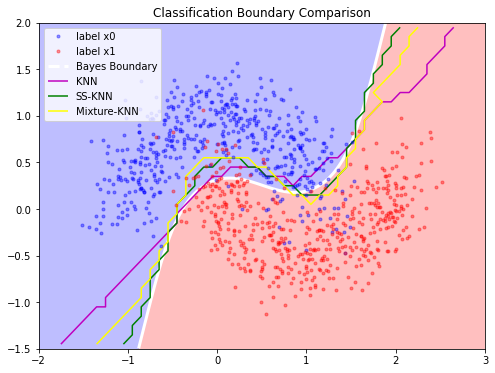

In [82]:
x, y = knn.generate_two_moon(N, noise = 0.25)
AA = average(pa)
BB = average(pb)
CC = average(pc)
AA = AA.reshape(xx.shape)
BB = BB.reshape(xx.shape)
CC = CC.reshape(xx.shape)
f, axarr = plt.subplots(1,1, sharex='col', sharey='row', figsize=(8,6))
X, y = knn.generate_two_moon(1000, 0.25)
plt.contourf(Z, 0, alpha=0.5, cmap = "bwr_r", extent=(-2,3,-1.5,2))
axarr.plot(X[y == 0][:, 0], X[y == 0][:, 1], '.',
        alpha=0.4, label='label x0', color='blue')
axarr.plot(X[y == 1][:, 0], X[y == 1][:, 1], '.',
        alpha=0.4, label='label x1', color='red')
cs = axarr.contour(Z,0,linewidths=3,colors='w', origin='lower', extent=(-2,3,-1.5,2))
cs.collections[0].set_label("Bayes Boundary")
cs = axarr.contour(AA, 0, linewidths=1.5, colors='m', origin='lower', extent=(-2,3,-1.5,2))
cs.collections[0].set_label("KNN")
cs = axarr.contour(BB, 0, linewidths=1.5, colors='green', origin='lower', extent=(-2,3,-1.5,2))
cs.collections[0].set_label("SS-KNN")
cs = axarr.contour(CC, 0, linewidths=1.5, colors='yellow', origin='lower', extent=(-2,3,-1.5,2))
cs.collections[0].set_label("Mixture-KNN")


axarr.set_title("Classification Boundary Comparison")
axarr.legend(fontsize=10, loc = "upper left")
# axarr.scatter(X_B[:, 0], X_B[:, 1], color='gold', s=10)
# axarr.scatter(X_A[y_A==0][:, 0], X_A[y_A==0][:, 1], c='royalblue', s=10)
# axarr.scatter(X_A[y_A==1][:, 0], X_A[y_A==1][:, 1], c='coral', s=10)
plt.show()